# Purpose

This project aims to **demystify neural networks** by guiding you through building one from scratch using Python and NumPy. We'll train our neural network on the **MNIST Dataset**, which comprises 70,000 handwritten digit images (0-9), each sized at 28x28 pixels. By the end of this tutorial, you'll have a trained model capable of recognizing digits with an accuracy exceeding 90%.

## Introduction to Neural Networks
Neural networks are computational models inspired by the human brain's interconnected network of neurons. They are capable of recognizing complex patterns and relationships within data, making them powerful tools for tasks like image and speech recognition.

For this project, we'll use a **feedforward neural network** to keep things straightforward. Here's the structure we'll implement:

* Input Layer: 784 neurons (28x28 pixels of each MNIST image).
* Hidden Layer 1: 32 neurons.
* Hidden Layer 2: 16 neurons.
* Output Layer: 10 neurons (representing digits 0-9).

This setup is designed for **multi-class classification**, where the network predicts the most probable class (digit) for a given input image.

## Step 1: Load the dataset

In this step, we'll download the MNIST dataset, extract the data and labels, split the data into training and testing sets, and visualize some sample images.

---

### 1.1 Download Dataset and Define Network Architecture

We'll use the `openml` library to fetch the MNIST dataset. This library simplifies dataset management, allowg us to download and access data seamlessly.

Then, we'll define the network architecture stated above allowing us to use these variables throughout the program.

In [1]:
import openml
import numpy as np
import matplotlib.pyplot as plt

# Download MNIST dataset from OpenML
mnist = openml.datasets.get_dataset(554)    # ID for MNIST

# Define network architecture
input_size = 28 * 28         # 784 input neurons
hidden_sizes = [32, 16]      # Two hidden layers with 32 and 16 neurons
output_size = 10             # 10 output neurons for digits 0-9
layer_dims = [input_size] + hidden_sizes + [output_size]


### 1.2 Extract Data and Labels

After downloading, we'll extract the feature data (`x`) and labels (`y`):

* x: Contains the pixel data for each image, reshaped into a 784-dimensional vector (28x28 pixels).
* y: Contains the integer labels (0-9) corresponding to each image

We'll also **normalize** the pixel values to the range [0, 1] for faster and more stable training.

In [2]:
# Extract data and labels from dataset
x, y, _, _ = mnist.get_data(target=mnist.default_target_attribute)

# Normalize pixel values and reshape data
x = x.to_numpy().reshape(-1, 28 * 28).astype(np.float32) / 255.0
y = y.astype(int)


### 1.3 Split Data into Training and Testing Sets

To evaluate our model's performance, we'll divid the dataset into

* Training Set: 60,000 images used to train the neural network.
* Testing set: 10,000 images used to asses the model's accuracy.

In [3]:
# Split data into training and testing sets
x_train, x_test = x[:60000].T, x[60000:].T  # Transpose to shape (784, number_of_samples)
y_train, y_test = y[:60000], y[60000:]

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


x shape: (70000, 784)
y shape: (70000,)
x_train shape: (784, 60000), x_test shape: (784, 10000)
y_train shape: (60000,), y_test shape: (10000,)


### 1.4 Visualizing Sample Space

Visualizing a subset of the dataset helps in understanding the data we're working with. We'll display 25 random images from the training set along with their labels.

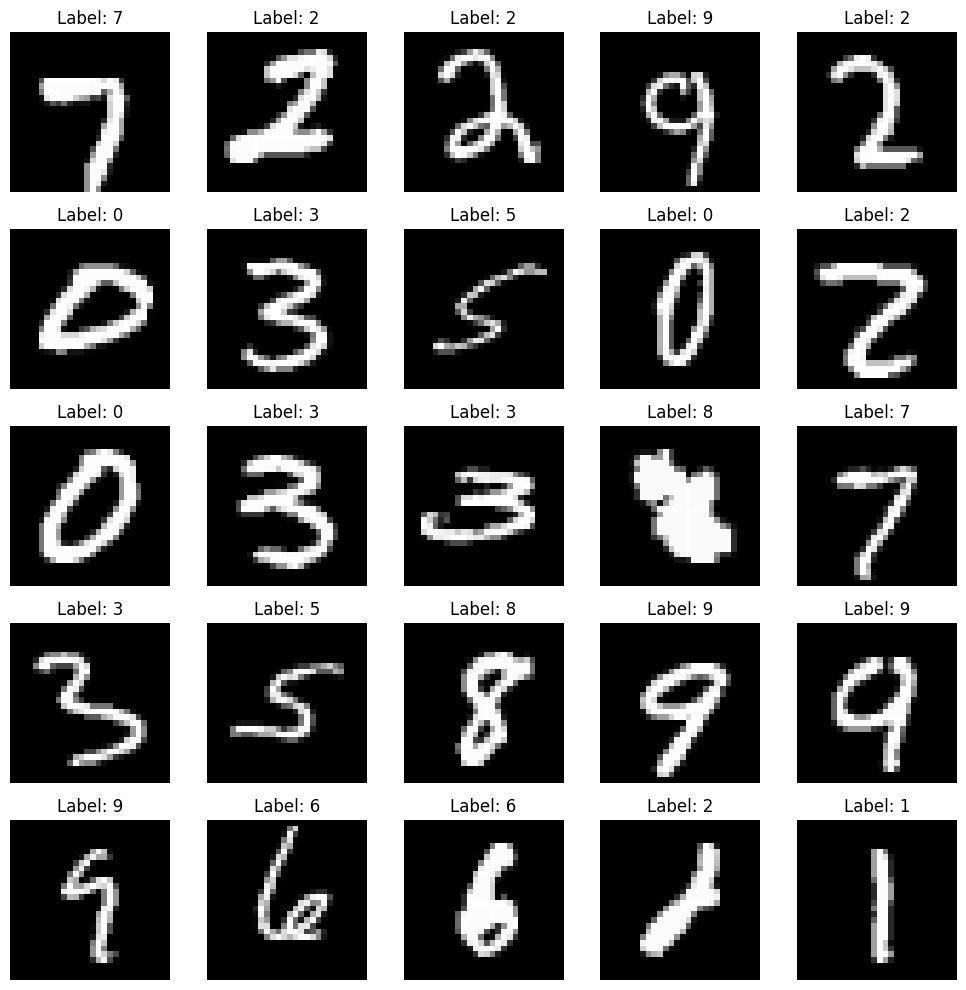

In [4]:
# Function to visualize sample images
def visualize_samples(x, y, num_samples=25):

    plt.figure(figsize=(10,10))
    indices = np.random.choice(x.shape[1], num_samples, replace=False)

    for i, idx in enumerate(indices):

        image = x[:, idx].reshape(28, 28)
        label = y[idx]

        plt.subplot(5, 5, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize sample images from the training set
visualize_samples(x_train, y_train)


## Step 2 Weights and Biases

Neural networks rely on **weights** and **biases** to learn patterns in data. Proper initialization is crucial for effective training.

---

### 2.1 Initializing Weights and Biases

* Weights: Determine the strength of connections between neurons. We'll use He initialization to set the initial weights, which helps in maintaining a good variance of activations throughout the network.
* Biases: Allow the activation functions to be shifted, enabling the network to fit data better. We'll initialize biases to zeros.

For each layer $i$:

* Weights: $ W^{[i]} \sim N (0, \frac{2}{n^{[i - 1]}}) $
* Biases: $ b^{[i]} = 0 $

In [5]:
def initialize_parameters(layer_dims):

    # Arrays to store our list of weights and biases
    weights = []
    biases = []

    # Loop through number of layers for initialization
        # Weights should be random variables
        # Biases should be set to 0
    for i in range(1, len(layer_dims)):

        # He initialization
        w = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(2. / layer_dims[i - 1])
        b = np.zeros((layer_dims[i], 1))
        weights.append(w)
        biases.append(b)

    return weights, biases


### Step 2.2 Visualizing the Neural Network

Understanding the architecture visually can provide clarity on how data flows through the network. We'll create a simplified diagram of our neural network.

* Input Layer: Represents the 784 input neurons (pixels). Due to space constraints, only a subset is displayed with an ellipsis (...) indicating the skipped neurons.
* Hidden Layers: Contain 32 and 16 neurons, respectively, that process the inputs.
* Output Layer: Comprises 10 neurons corresponding to the digits 0-9.

Connections: Lines between neurons signify the weighted connections. Faint lines indicate a fully connected network.

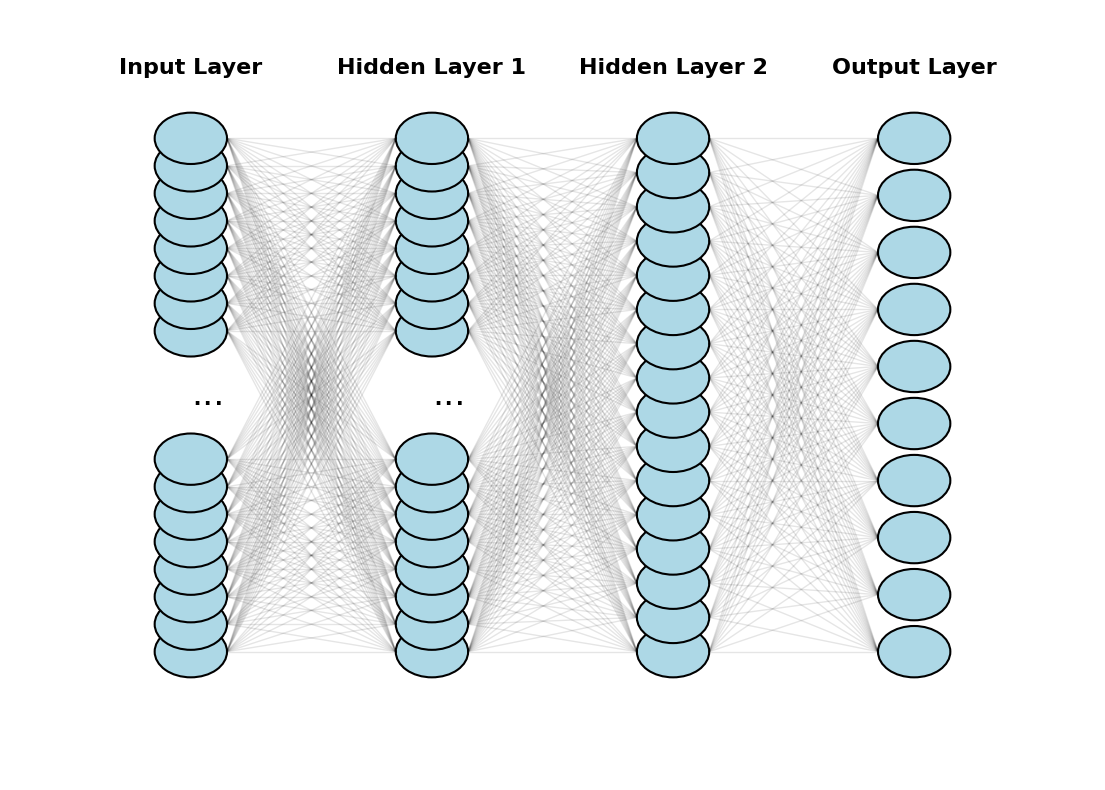

In [6]:
import matplotlib.patches as patches

def draw_neural_network(layer_dims, max_display=16):

    total_layers = len(layer_dims)
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis('off')

    neuron_size = 0.4  # Circle size for each neuron
    neuron_color = 'lightblue'
    
    # Function to generate neuron positions for a layer
    def generate_layer_positions(x_position, n_neurons):
        if n_neurons > max_display:

            displayed_neurons = max_display // 2
            positions = np.linspace(2, 5, displayed_neurons).tolist() + \
                        np.linspace(7, 10, displayed_neurons).tolist()
        else:

            positions = np.linspace(2, 10, n_neurons)

        return [(x_position, y) for y in positions]
    
    layers = []
    x_positions = np.linspace(2, 10, total_layers)

    for idx, n_neurons in enumerate(layer_dims):

        layer = generate_layer_positions(x_positions[idx], n_neurons)
        layers.append(layer)
    
    # Draw neurons
    for layer in layers:

        for neuron in layer:

            circle = patches.Circle(neuron, neuron_size, fill=True, color=neuron_color, ec='k', lw=1.5)
            ax.add_patch(circle)
    
    # Draw connections
    for i in range(len(layers) -1):

        layer1 = layers[i]
        layer2 = layers[i+1]

        for n1 in layer1:

            for n2 in layer2:

                ax.plot([n1[0]+0.4, n2[0]-0.4], [n1[1], n2[1]], 'k-', alpha=0.1, lw=1)
    
    # Add '...' to indicate skipped neurons
    for idx, layer in enumerate(layers):

        n_neurons = layer_dims[idx]

        if n_neurons > max_display:

            ax.text(x_positions[idx], 6, '...', fontsize=25, verticalalignment='center', color='black')
    
    # Layer labels
    layer_names = ['Input Layer'] + [f'Hidden Layer {i+1}' for i in range(len(layer_dims)-2)] + ['Output Layer']

    for idx, name in enumerate(layer_names):
        
        ax.text(x_positions[idx], 11, name, horizontalalignment='center', fontsize=16, fontweight='bold')
    
    plt.show()

# Visualize the neural network architecture
draw_neural_network(layer_dims)





## Step 3: Activation and Loss Functions

Activation functions introduce non-linearity into the network, enabling it to learn complex patterns. The loss function measures how well the neural network is performing by comparing its predictions with the true labels.

---

### 3.1 Sigmoid Activation Function

The sigmoid function introduces non-linearity into the network, enabling it to learn complex patterns. The function squashes input values into a range between 0 and 1, while keeping relative scale consistent and is commonly used in hidden layers.
$$\sigma (z) = \frac{1}{1 + e^{-z}}$$
*We won't be using this function as it ReLU tends to perform better, but it's still good to know about!*

In [7]:
def sigmoid(z):

    return 1 / (1 + np.exp(-z))


#### 3.1.1 Sigmoid Function Visualization

This will allow us to see how values are squished between 0 and 1 on the y-axis while extending on the x-axis. 

* S-shape Curve: The sigmoid function smoothly maps any input value to a value between 0 and 1.
* Threshold Behavior: Values around 0 are mapped to 0.5, while large positive or negative inputs approach 1 or 0, respectively.

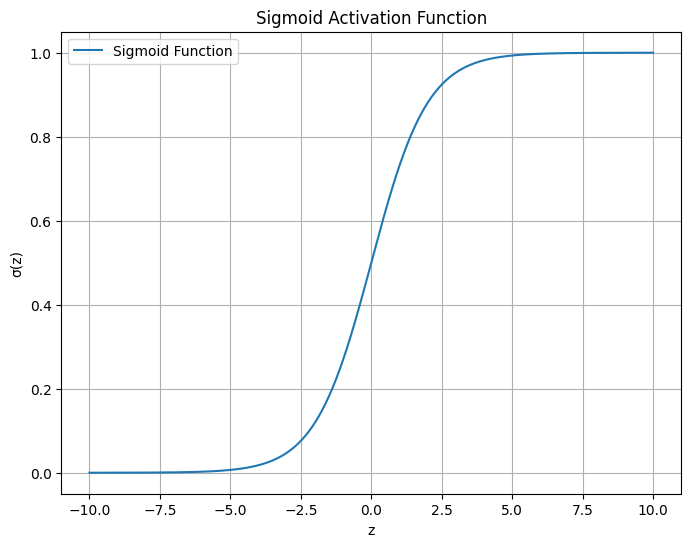

In [8]:
# Generate input values
z = np.linspace(-10, 10, 1000)
sigmoid_z = sigmoid(z)

# Plot sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_z, label='Sigmoid Function')
plt.title('Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.grid(True)
plt.legend()
plt.show()


### 3.2 Sigmoid Derivative

The derivative of the function above is necessary for a concept known as backpropagation that we'll get to later. For now, know that the derivative tells us the slope of a point on the sigmoid function.

$$\sigma'(z) = \sigma (z) \cdot (1 - \sigma(z))$$

In [9]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)


#### 3.2.1 Sigmoid Derivative Visualization

Visualizing the derivative helps understand how the gradient behaves at different input values.

* Peak at z = 0: The derivative is highest when the input to sigmoid is 0.
* Symmetric Decay: The derivative decreases as the input moves away from 0, approaching 0 for large positive or negative inputs.

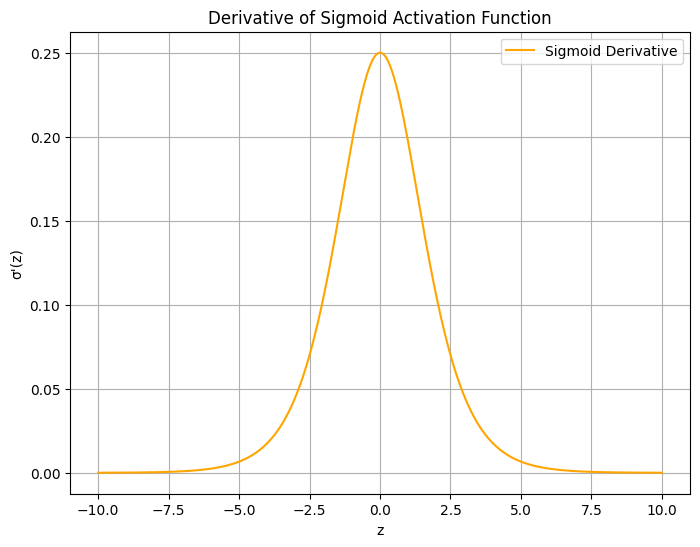

In [10]:
# Compute derivative
sigmoid_derivative_z = sigmoid_derivative(z)

# Plot derivative
plt.figure(figsize=(8, 6))
plt.plot(z, sigmoid_derivative_z, label='Sigmoid Derivative', color='orange')
plt.title('Derivative of Sigmoid Activation Function')
plt.xlabel('z')
plt.ylabel("σ'(z)")
plt.grid(True)
plt.legend()
plt.show()



### 3.3 ReLU Function

ReLU stands for Rectified Linear Unit and is widely used in hidden layers of neural networks due to its simplicity and effectiveness.

$$ \text{ReLU}(z) = \text{max}(0, z) $$

In [11]:
def relu(z):
    
    return np.maximum(0, z)


#### 3.3.1 ReLU Function Visualization

* 0 for Negative Inputs: ReLU ouputs zero for all negative input values.
* Linear for Positive Inputs: ReLU outputs the input value directly for positive inputs.

Advantages of ReLU:

* Computational Efficiency: Simpler computation compared to the Sigmoid function.
* Avoids Vanishing Gradient: keeps gradients significant for positive inputs.

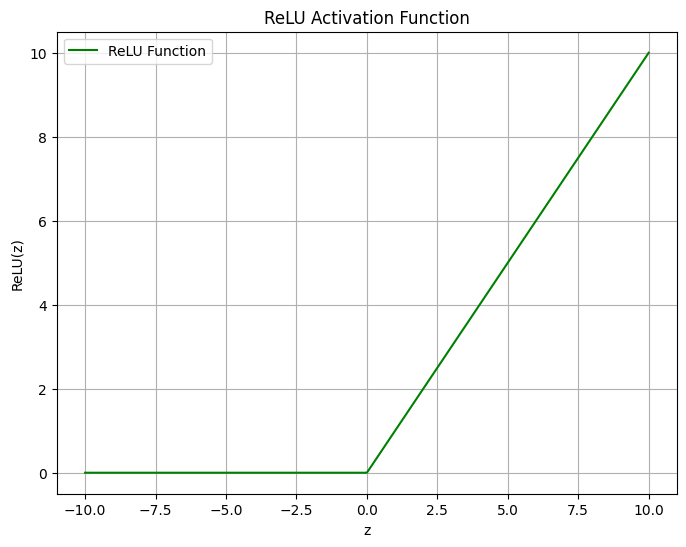

In [12]:
# Generate input values
z = np.linspace(-10, 10, 1000)
relu_z = relu(z)

# Plot ReLU function
plt.figure(figsize=(8, 6))
plt.plot(z, relu_z, label='ReLU Function', color='green')
plt.title('ReLU Activation Function')
plt.xlabel('z')
plt.ylabel('ReLU(z)')
plt.grid(True)
plt.legend()
plt.show()


#### 3.4 ReLU Derivative

Just like the Sigmoid function, the ReLU derivative is necessary during backpropagation. This will help us calculate the gradient of our networks layers.

$$ ReLU'(z) = 
\begin{cases}
    1 & \text{if } z > 0 \\
    0 & otherwise
\end{cases} $$

In [13]:
def relu_derivative(z):
    
    return (z > 0).astype(float)

#### 3.4.1 ReLU Derivative Visualization

This will show you what function we use during backpropagation.

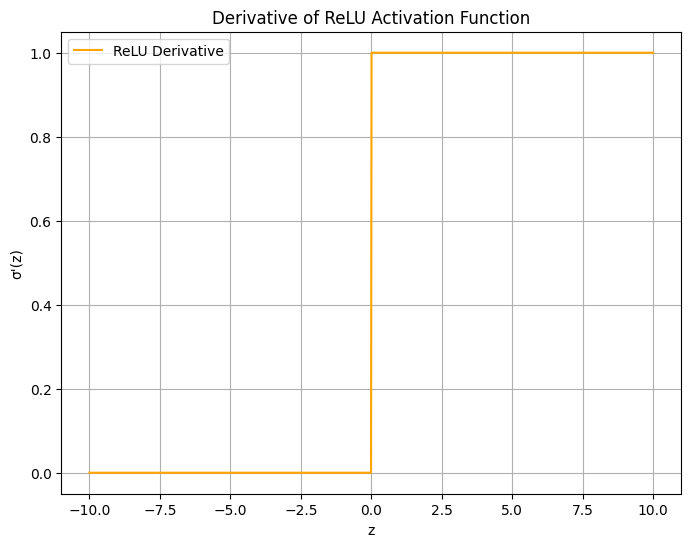

In [14]:
# Compute derivative
relu_derivative_z = relu_derivative(relu_z)

# Plot derivative
plt.figure(figsize=(8, 6))
plt.plot(z, relu_derivative_z, label='ReLU Derivative', color='orange')
plt.title('Derivative of ReLU Activation Function')
plt.xlabel('z')
plt.ylabel("σ'(z)")
plt.grid(True)
plt.legend()
plt.show()

### 3.5 Softmax Function

The softmax function converts raw scores into probabilities, making it suitable for multi-class classification in the output layer.

* Probability Distribution: Softmax converts raw scores into probabilities that sum to 1.
* Exponentiation: Higher scores get exponentially more weight, making them more probable.

$$softmax(z_i) = \frac{e^{z_i}}{\sum_{j}e^{z_j}}$$

In [15]:
def softmax(z):
    
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))

    return exp_z / exp_z.sum(axis=0, keepdims=True)

#### 3.5.1 Softmax Visualization

Here are some examples using `[2.0, 1.0, and 0.1]`. The softmax function will turn these scores into probabilities that total to 1.

* Probability Distribution: Softmax convers raw scores into probabilities that sum to 1.
* Exponentiation: Higher scores get exponentially more weight, making them more probable.

Sum of probabilities: 1.0


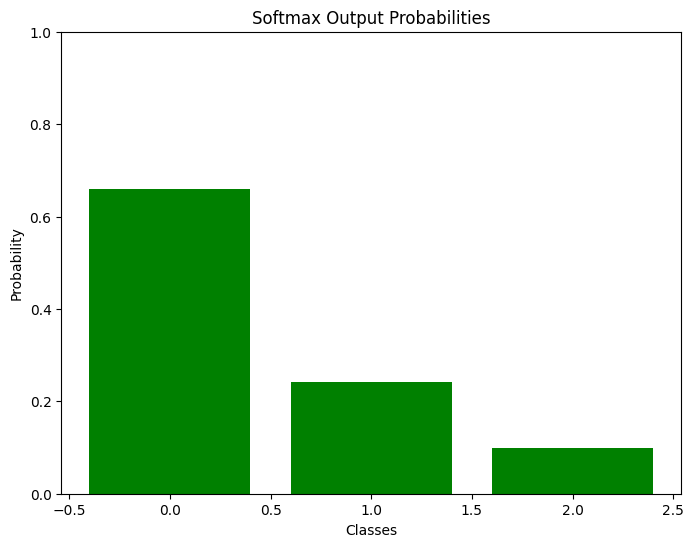

In [16]:
def plot_softmax(scores):
    
    scores = np.array(scores)
    probabilities = softmax(scores.reshape(-1, 1)).flatten()
    print("Sum of probabilities:", np.sum(probabilities))

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(scores)), probabilities, color='green')
    plt.title('Softmax Output Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.show()

# Example usage:
sample_scores = [2.0, 1.0, 0.1]
plot_softmax(sample_scores)


### 3.4 Cross-Entropy Loss

The loss function measures how well the neural network's predictions match the actual labels. For multi-class classification, **cross-entropy loss** is commonly used.

$$ L = - \frac{1}{m}\sum_{i = 1}^m \log A_{y^{(i)}, i}^{[L]} $$

Where:
* $m$ = number of samples
* $A_{y^{(i)}, i}^{[L]}$ = predictied probability of the true class for example $i$

In [17]:
def compute_loss(aL, y):

    m = y.shape[0]

    epsilon = 1e-15
    aL_clipped = np.clip(aL, epsilon, 1 - epsilon)

    log_probs = -np.log(aL_clipped[y, np.arange(m)])
    
    loss = np.sum(log_probs) / m

    return loss


## Step 4: Forward and Backward Propagation

Propagation serves as the way values are computed in the network and how we tune the parameters of the network to make the probabilities better throughout training.

---

### 4.1 Forward Propagation

Forward propagation involves computing the activations for each layer given the input data and the current parameters. It computes the output of the network by sequentially processing the input through each layer.

for each layer $i$:
1. Linear Step: Compute $ Z^{[l]} = W^{[l]}A^{[l - 1]} + b^{[l]} $
2. Activation Step: Apply activation function to get $ A^{[l]} $

* For hidden layers, use ReLU:
    * $ A^{[l]} = \text{ReLU}(Z^{[l]}) $
* For output layer, use Softmax:
    * $ A^{[l]} = \text{Softmax}(Z^{[l]}) $

In [18]:
def forward_propagation(x, weights, biases):

    activations = [x]
    zs = []

    for i in range(len(weights) - 1):

        z = np.dot(weights[i], activations[-1]) + biases[i]
        zs.append(z)

        a = relu(z)
        activations.append(a)

    z = np.dot(weights[-1], activations[-1]) + biases[-1]
    zs.append(z)
    a = softmax(z)
    activations.append(a)

    cache = {'activations': activations, 'zs': zs}

    return activations[-1], cache

#### 4.1.1 Visualizing Forward Propagation

To visualize forward propagation, we'll focus on a single input sample and track how the activations change as the input moves through each layer of the network.

* Input Image: Displays the original image from the test set.
* Layer Activations: Shows the activations of neurons in each hidden layer.
* Output Probabilities: Bar chart showing the probabilities for each class (digit 0-9).

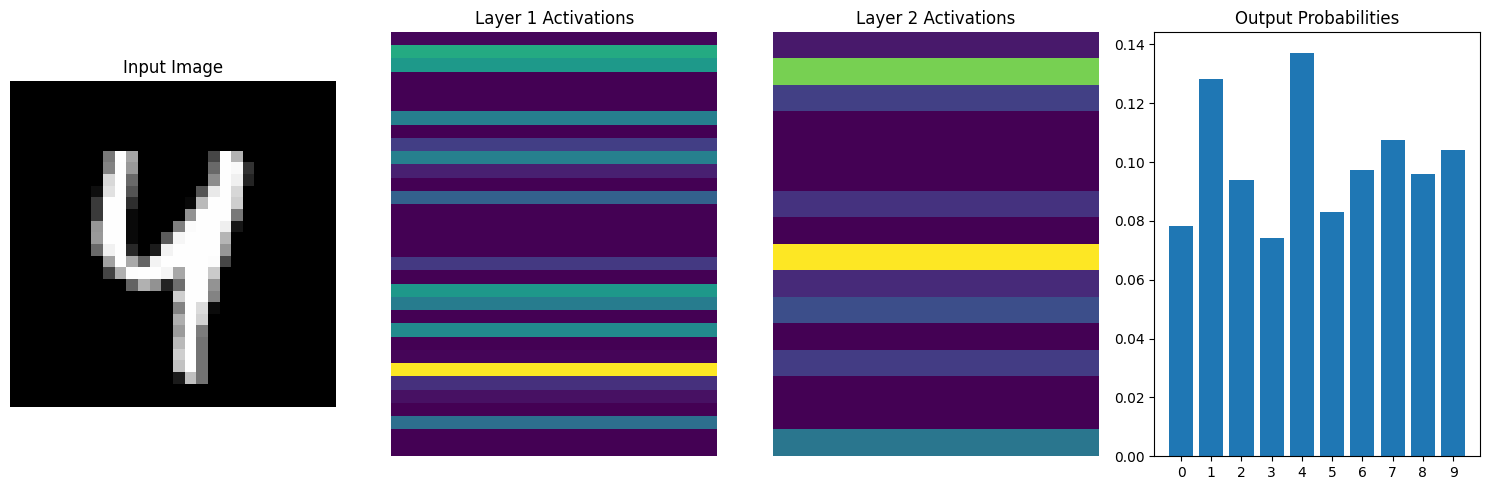

This data isn't valuable because the network isn't trained yet!


In [19]:
def visualize_forward_propagation(x_sample, weights, biases):
    
    activations = [x_sample]
    zs = []

    # Forward propagation through hidden layers
    for i in range(len(weights) - 1):
        z = np.dot(weights[i], activations[-1]) + biases[i]
        zs.append(z)
        a = relu(z)
        activations.append(a)

    # Output layer
    z = np.dot(weights[-1], activations[-1]) + biases[-1]
    zs.append(z)
    a = softmax(z)
    activations.append(a)

    # Plot activations
    num_layers = len(activations)
    fig, axes = plt.subplots(1, num_layers, figsize=(15, 5))
    layer_names = ['Input'] + [f'Layer {i}' for i in range(1, num_layers - 1)] + ['Output']

    for idx, ax in enumerate(axes):
        if idx == 0:
            # Input layer (image)
            ax.imshow(activations[idx].reshape(28, 28), cmap='gray')
            ax.set_title('Input Image')
            ax.axis('off')
        elif idx == num_layers - 1:
            # Output layer (probabilities)
            ax.bar(range(10), activations[idx].flatten())
            ax.set_xticks(range(10))
            ax.set_title('Output Probabilities')
        else:
            # Hidden layers
            activation = activations[idx]
            ax.imshow(activation, aspect='auto', cmap='viridis')
            ax.set_title(f'Layer {idx} Activations')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Sample index to compute
sample_index = 42

weights, biases = initialize_parameters(layer_dims)

# Convert y_test to a NumPy array
if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()


# Verify sample_index is within bounds
assert 0 <= sample_index < y_test.shape[0], "Sample index out of range."

# Select a sample from the test set
x_sample = x_test[:, sample_index].reshape(-1, 1)  # (784, 1) shape to match the model input
y_sample = y_test[sample_index]

# Visualize forward propagation
visualize_forward_propagation(x_sample, weights, biases)

print(f"This data isn't valuable because the network isn't trained yet!")



### 4.2 Backward Propagation

Backward propagation (backpropagation) is the process by which the neural network learns by updating its weights and biases based on the error of its predictions

It involves calculating the gradients of the loss function with respect to each parameter and adjusting them to minimize the loss.

For the output layer $ L $:
* Error Term: $ \delta^{[L]} = A^{[L]} - Y_{one-hot} $

For hidden layers $ l $:
* Error Term: $ \delta^{[l]} = (W^{[l + 1]})^T \delta^{[l + 1]} \times \text{ReLU}'(Z^{[l]}) $

Gradients:
* $ dW^{[l]} = \frac{1}{m} \delta^{[l]}(A^{[l - 1]})^T $
* $ db^{[l]} = \frac{1}{m} \sum_{i = 1}^{m} \delta^{[l]} $

In [20]:
def back_propagation(y, cache, weights):

    m = y.shape[0]
    activations = cache['activations']

    gradients_w = []
    gradients_b = []

    y_one_hot = np.zeros_like(activations[-1])
    y_one_hot[y, np.arange(m)] = 1

    delta = activations[-1] - y_one_hot
    dw = np.dot(delta, activations[-2].T) / m
    db = np.sum(delta, axis=1, keepdims=True) / m

    gradients_w.append(dw)
    gradients_b.append(db)

    for l in range(len(weights) - 2, -1, -1):

        delta = np.dot(weights[l + 1].T, delta) * relu_derivative(activations[l + 1])

        dw = np.dot(delta, activations[l].T) / m
        db = np.sum(delta, axis=1, keepdims=True) / m

        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)

    gradients = {'dw': gradients_w, 'db': gradients_b}

    return gradients


### 4.2.1 Visualize Backward Propagation

To visualize backward propagation, we'll again focus on a single input sample and track the gradients flowing backward through the network.
* Backward Pass:
    * Gradients of the loss with respect to each parameter are computed.
    * Gradients flow backward from the output layer to the hidden layer.


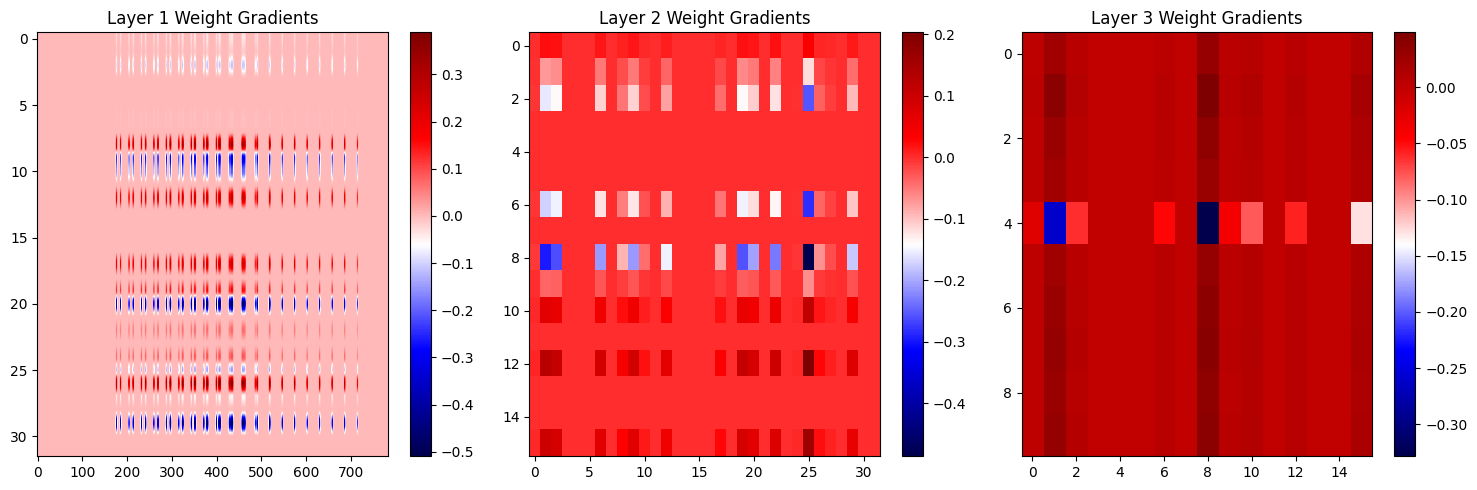

In [21]:
def visualize_backward_propagation(x_sample, y_sample, weights, biases):

    # Perform forward propagation
    aL, cache = forward_propagation(x_sample, weights, biases)
    
    # Convert y_sample to a batch
    y_sample_batch = np.array([y_sample])
    
    # Perform backward propagation
    gradients = back_propagation(y_sample_batch, cache, weights)
    
    # Extract gradients
    delta_ws = gradients['dw']
    delta_bs = gradients['db']
    
    num_layers = len(delta_ws)
    fig, axes = plt.subplots(1, num_layers, figsize=(15, 5))
    
    for idx in range(num_layers):
        
        # For visualization purposes, we'll visualize the gradients of the weights
        gradient = delta_ws[idx]
        # Reshape gradient to a 2D array for visualization
        grad_image = gradient
        im = axes[idx].imshow(grad_image, aspect='auto', cmap='seismic')
        axes[idx].set_title(f'Layer {idx+1} Weight Gradients')
        plt.colorbar(im, ax=axes[idx])
    
    plt.tight_layout()
    plt.show()

# Visualize backward propagation
visualize_backward_propagation(x_sample, y_sample, weights, biases)



## Step 5: Parameters, Predictions, and Accuracy

In this section, we'll delve into how to update the neural network's parameters, make predictions using the trained model, and evaluate its accuracy. Understanding these components is crucial for effectively training and assessing the performance of your neural network.

---

### 5.1 Updating Parameters

Updating the weights and biases is a fundamental step in training a neural network. We'll utilize gradient descent to adjust these parameters in a direction that minimizes the cross-entropy loss function from earlier.

Updates the weights and biases during learning using gradient descent.
* Subtract the product of learning_rate and gradient from current weights.
    * This moves the weights in the opposite direction of the gradient, reducing loss.

$$ \theta = \theta - \alpha \cdot \nabla_{\theta}L $$

Where:
* $ \theta $ = weights or biases.
* $ \alpha $ = learning rate.
* $ \nabla_{\theta}L $ = gradient of the loss with respect to $ \theta $.

In [22]:
def update_parameters(weights, biases, gradients, learning_rate):

    for i in range(len(weights)):

        weights[i] -= learning_rate * gradients['dw'][i]
        biases[i] -= learning_rate * gradients['db'][i]

    return weights, biases


#### 5.1.1 Visualizing Parameter Updates

Visualizing how weights change during training can provide insights into the learning process. We'll compare weights before and after an update for a subset of neurons.

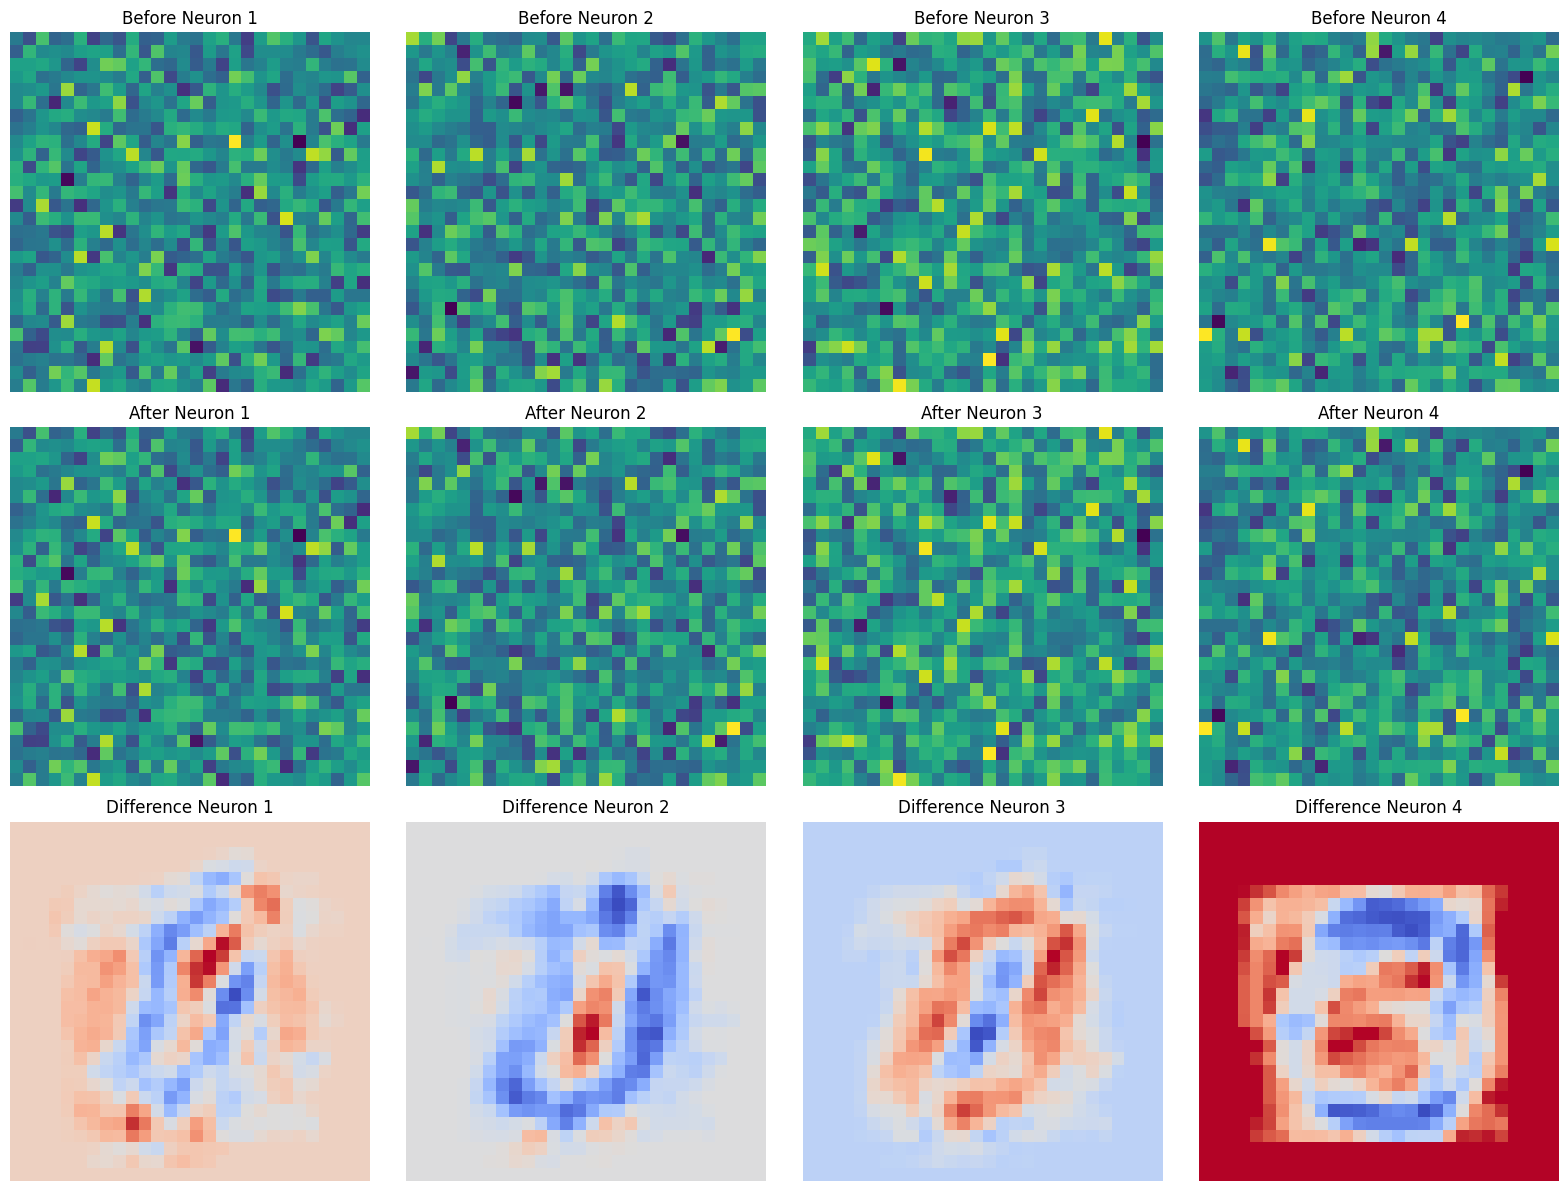

In [23]:
import copy

def visualize_parameter_updates(weights_before, weights_after, layer=0, num_weights=4):

    # Restrict number of weights to display (we'll display only 4 neurons per before and after)
    num_weights = min(num_weights, weights_before[layer].shape[0])

    # Automatically calculate the number of columns for subplots
    cols = 4  # Fixed number of columns
    rows = 3  # One row for "Before", one for "After", one for "Difference"
    
    # Create a figure for displaying the subplots
    plt.figure(figsize=(16, 12))  # Adjust figure size based on the number of rows
    
    for i in range(num_weights):

        # Plot "Before" update weights
        plt.subplot(rows, cols, i + 1)
        plt.imshow(weights_before[layer][i].reshape(28, 28), cmap='viridis')
        plt.title(f'Before Neuron {i + 1}')
        plt.axis('off')
        
        # Plot "After" update weights
        plt.subplot(rows, cols, i + 1 + cols)
        plt.imshow(weights_after[layer][i].reshape(28, 28), cmap='viridis')
        plt.title(f'After Neuron {i + 1}')
        plt.axis('off')
        
        # Plot Difference (After - Before)
        plt.subplot(rows, cols, i + 1 + 2 * cols)
        difference = weights_after[layer][i] - weights_before[layer][i]
        plt.imshow(difference.reshape(28, 28), cmap='coolwarm')  # Use a diverging colormap for differences
        plt.title(f'Difference Neuron {i + 1}')
        plt.axis('off')
    
    plt.tight_layout()  # Ensure subplots fit nicely without overlap
    plt.show()

# Hyperparameters for training
learning_rate = 0.1     # Small step size for gradient descent
num_epochs = 10         # Number of training epochs
batch_size = 64         # Size of batches of data

# Clone weights before update
weights_before_update = copy.deepcopy(weights)

# Perform forward pass on the batch (pseudo-code, ensure functions are available)
aL, cache = forward_propagation(x_train[:, :batch_size], weights, biases)

# Perform backpropagation using the batch
gradients = back_propagation(y_train[:batch_size], cache, weights)

weights, biases = update_parameters(weights, biases, gradients, learning_rate)

# Visualize updates for the first hidden layer (layer index 0)
visualize_parameter_updates(weights_before_update, weights, layer=0, num_weights=4)



### 5.2 Making Predictions

Once the network is trained, we can use it to make predictions on new data.

We'll leverage the forward propagation to compute the output probabilities and then selects the class with the highest probability as the prediction.

* Forward Propagation: Computes the output probabilities for each class.
* Argmax: Selects the index of the highest probability as the predicted class.

In [24]:
def predict(x, weights, biases):
    
    # Calculate output activations
    a2, _ = forward_propagation(x, weights, biases)

    # Array containing predicted labels for each input sample
    predictions = np.argmax(a2, axis=0)

    return predictions


#### 5.2.1 Visualizing Predictions

Visualizing predictions alongside true labels helps in assessing the model's performance and identifying misclassifications.

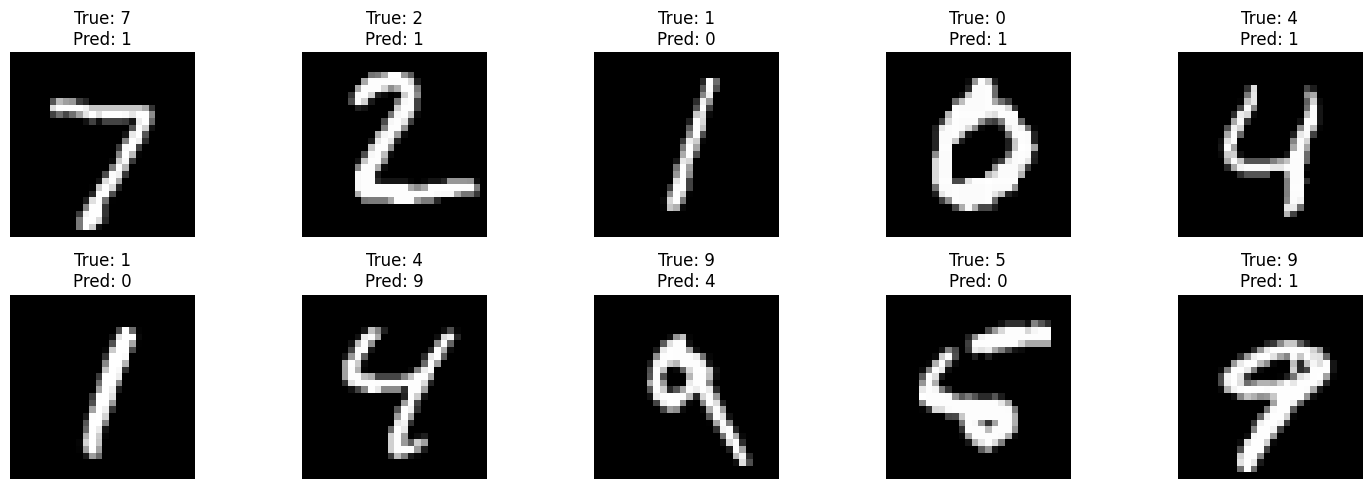

This data isn't valuable because the network isn't trained yet!


In [25]:
def visualize_predictions(x, y_true, weights, biases, num_samples=10):

    predictions = predict(x, weights, biases)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):

        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(x[:, i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[i]}\nPred: {predictions[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on the first 10 test samples
x_test_subset = x_test[:, :10]
y_test_subset = y_test[:10]

visualize_predictions(x_test_subset, y_test_subset, weights, biases, num_samples=10)

print(f"This data isn't valuable because the network isn't trained yet!")

### 5.3 Computing Accuracy

Accuracy is a straightforward metric to evaluate how well the model performs by comparing predicted labels against true labels.

In [26]:
def compute_accuracy(y_true, y_pred):
    
    return np.mean(y_true == y_pred) * 100

## Step 6: Training and Evaluating the Neural Network

This section integrates forward propagation, backpropagation, parameter updates, and evaluation metrics to establish a comprehensive training pipeline for the neural network.

---

### 6.1 Training the Neural Network

Our goal is to iteratively update hte network's parameters to minimize the loss function using gradient descent.

This function will perform forward propagation, compute loss, execute backpropagation, update parameters, and track accuracy over multiple epochs.

* Shuffling Data: Randomizes the order of training samples each epoch to ensure that the model doesn't learn patterns based on the data sequence.
* Mini-Batch Gradient Descent: Divides the training data into smaller batches, which can lead to faster convergence and better generalization.
* Forward Propagation: Computes the output probabilities for the current batch.
* Backward Propagation: Calculates the gradients of the loss function with respect to each parameter.
* Parameter Updates: Adjusts the weights and biases using the computed gradients and the specified learning rate.
Loss Tracking: Records the loss after each epoch to monitor training progress.

In [27]:
def train_neural_network(x_train, y_train, weights, biases, learning_rate, num_epochs, batch_size, x_val=None, y_val=None):
    
    m = x_train.shape[1]
    loss_history = []
    accuracy_history = []

    for epoch in range(1, num_epochs + 1):
        # Shuffle the training data
        permutation = np.random.permutation(m)
        x_train_shuffled = x_train[:, permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, m, batch_size):
            x_batch = x_train_shuffled[:, i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            # Forward propagation
            aL, cache = forward_propagation(x_batch, weights, biases)

            # Backward propagation
            gradients = back_propagation(y_batch, cache, weights)

            # Update parameters
            weights, biases = update_parameters(weights, biases, gradients, learning_rate)

        # Compute loss after each epoch
        aL_full, _ = forward_propagation(x_train, weights, biases)
        loss = compute_loss(aL_full, y_train)
        loss_history.append(loss)

        # Compute accuracy
        if x_val is not None and y_val is not None:
            # Validation accuracy
            y_pred_val = predict(x_val, weights, biases)
            accuracy = compute_accuracy(y_val, y_pred_val)
            accuracy_history.append(accuracy)
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
        else:
            # Training accuracy
            y_pred_train = predict(x_train, weights, biases)
            accuracy = compute_accuracy(y_train, y_pred_train)
            accuracy_history.append(accuracy)
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}, Training Accuracy: {accuracy:.2f}%")

    return weights, biases, loss_history, accuracy_history

#### 6.1.1 Visualizing Training Progress

Plotting the loss and accuracy over epochs provides insights into how well the model is learning.

* Loss Curve: Shows how the cross-entropy loss decreases over epochs, indicating that the model is learning to make better predictions.
* Forward Propagation: Computes the output probabilities for the entire test set.
* Prediction: Selects the class with the highest probability for each sample.
* Accuracy Calculation: Compares the predicted labels with the true labels to determine the percentage of correct predictions.

Neural Network Configuration:
------------------------------
Number of layers: 4
Layer 1 (784) -> Layer 2 (32): Weights shape: (32, 784), Biases shape: (32, 1)
Layer 2 (32) -> Layer 3 (16): Weights shape: (16, 32), Biases shape: (16, 1)
Layer 3 (16) -> Layer 4 (10): Weights shape: (10, 16), Biases shape: (10, 1)
Activation function: ReLU
Learning rate: 0.01
Number of epochs: 10
------------------------------
Starting training...
Epoch 1/10, Loss: 0.4990, Training Accuracy: 86.22%
Epoch 2/10, Loss: 0.3589, Training Accuracy: 89.93%
Epoch 3/10, Loss: 0.3124, Training Accuracy: 91.17%
Epoch 4/10, Loss: 0.2809, Training Accuracy: 91.94%
Epoch 5/10, Loss: 0.2632, Training Accuracy: 92.47%
Epoch 6/10, Loss: 0.2467, Training Accuracy: 93.00%
Epoch 7/10, Loss: 0.2334, Training Accuracy: 93.32%
Epoch 8/10, Loss: 0.2218, Training Accuracy: 93.64%
Epoch 9/10, Loss: 0.2153, Training Accuracy: 93.80%
Epoch 10/10, Loss: 0.2047, Training Accuracy: 94.12%
Training completed.


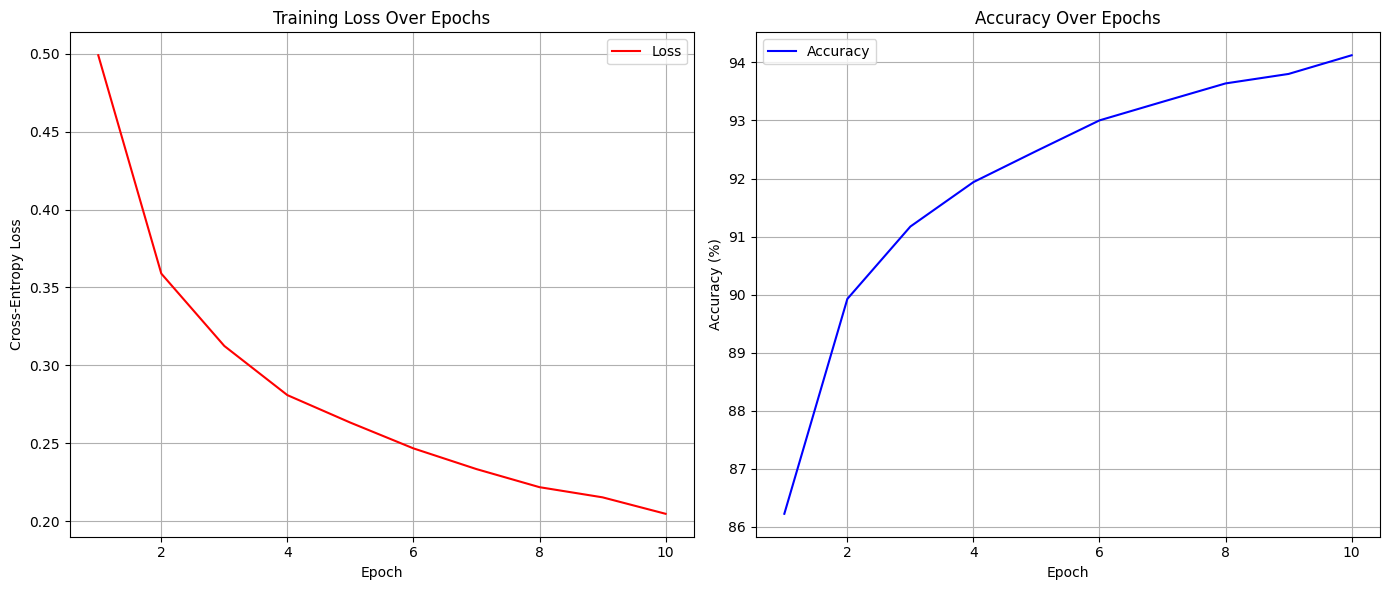

In [28]:
def plot_learning_curves(losses, accuracies):

    epochs = range(1, len(losses)+1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r-', label='Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy only if we have accuracy data
    if accuracies and len(accuracies) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracies, 'b-', label='Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Initialize parameters
weights, biases = initialize_parameters(layer_dims)

# Training hyperparameters
learning_rate = 0.01
num_epochs = 10

# Print network summary
print("Neural Network Configuration:")
print("-" * 30)
print(f"Number of layers: {len(layer_dims)}")
for i in range(len(layer_dims) -1):
    print(f"Layer {i+1} ({layer_dims[i]}) -> Layer {i+2} ({layer_dims[i+1]}): "
            f"Weights shape: {weights[i].shape}, Biases shape: {biases[i].shape}")
print(f"Activation function: ReLU")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print("-" * 30)

# Train the neural network
print("Starting training...")
weights, biases, loss_history, accuracy_history = train_neural_network(
    x_train, y_train, weights, biases, learning_rate, num_epochs, batch_size=64)

print("Training completed.")

plot_learning_curves(loss_history, accuracy_history)

### 6.2 Generating and Visualizing Evaluations

* A confusion matrix provides a detailed breakdown of correct and incorrect predictions across all classes, offering deeper insights into the model's performance.
* Visualizing predictions shows that our neural network correctly identifies numbers unlike it used to before training.
* Visualizing a single prediction shows us how the forward propagation has changed after training.

Test Accuracy: 93.89%


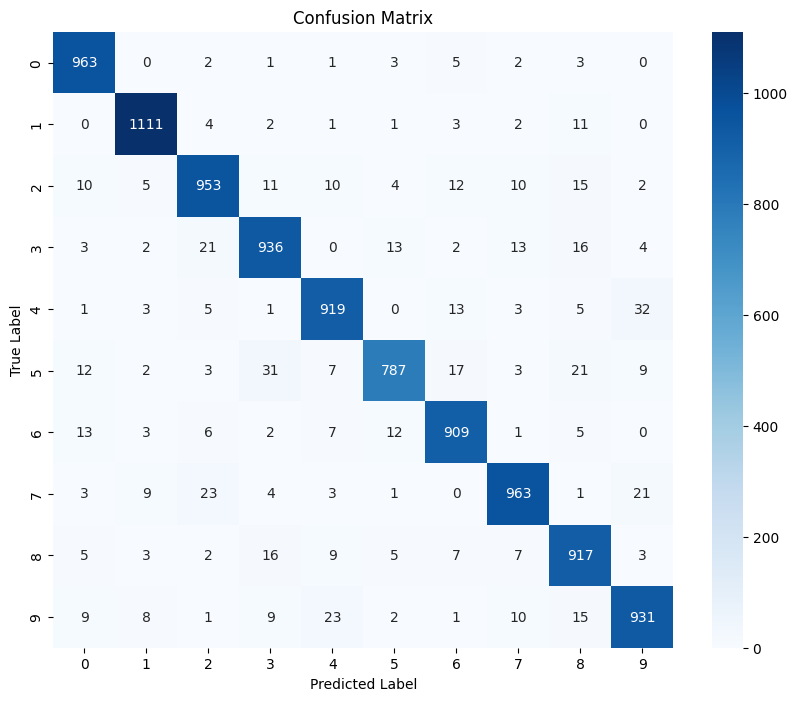

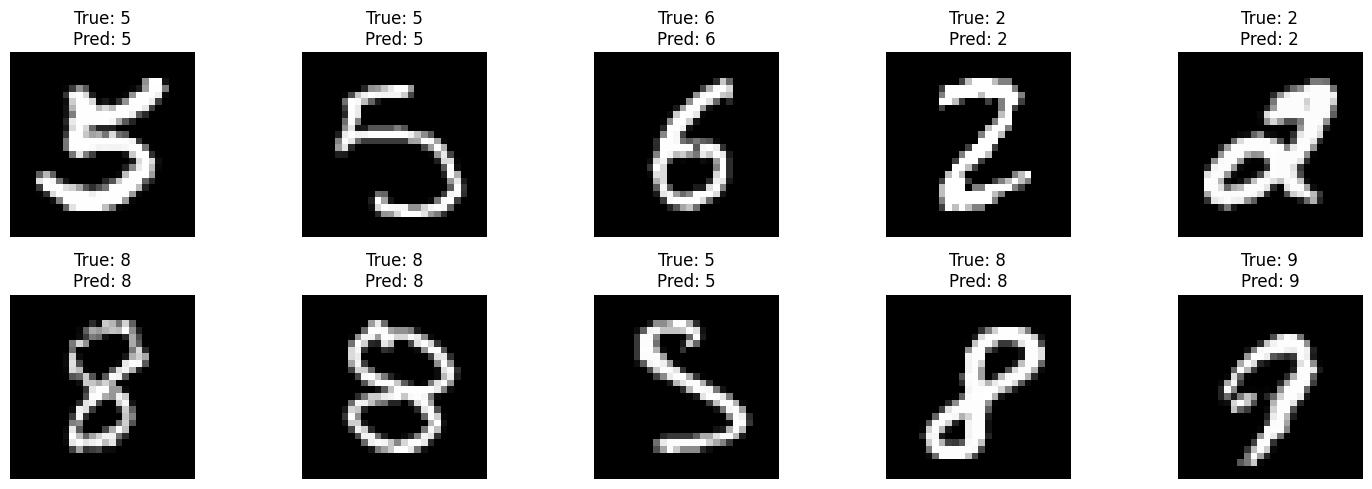

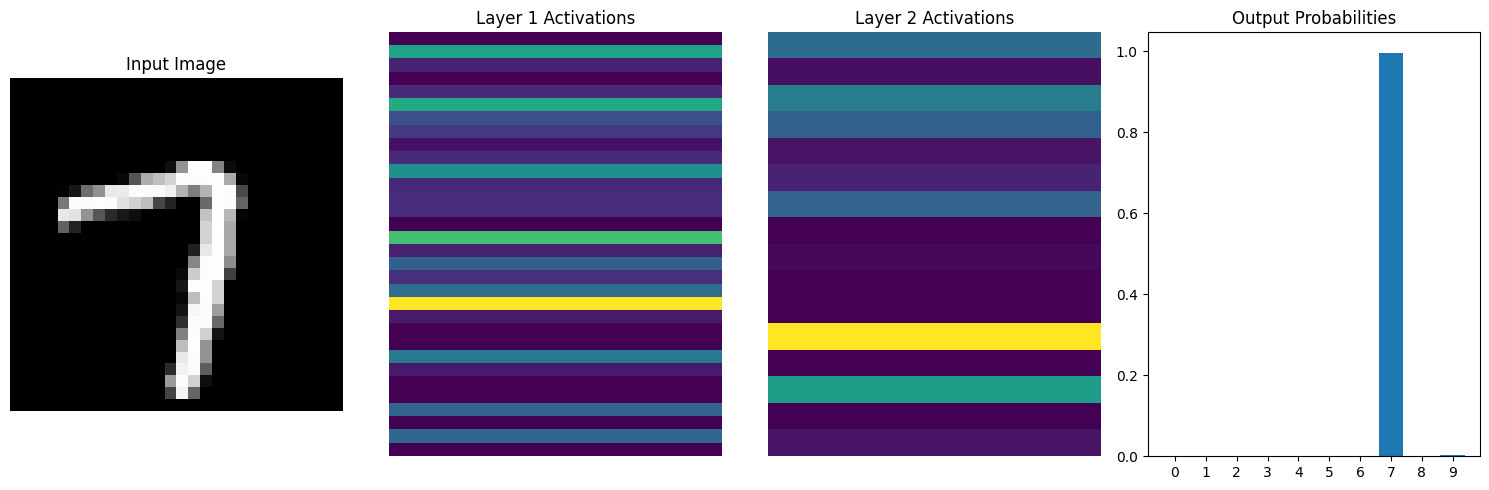

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define classes (digits 0-9)
classes = list(range(10))

# Predict labels on test set
y_pred_test = predict(x_test, weights, biases)

# Compute accuracy on the test set
test_accuracy = compute_accuracy(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot confusion matrix for the test set predictions
plot_confusion_matrix(y_test, y_pred_test, classes)

# Number of random samples to extract
num_samples = 10

# Randomly sample indices from the test set
random_indices = np.random.choice(x_test.shape[1], num_samples, replace=False)

# Extract the corresponding subset of x_test and y_test
x_test_subset = x_test[:, random_indices]
y_test_subset = y_test[random_indices]

# Visualize predictions now that the model is trained
visualize_predictions(x_test_subset, y_test_subset, weights, biases, num_samples=10)

# Randomly sample an index from the test set
random_index = np.random.choice(x_test.shape[1], 1, replace=False)

# Extract the corresponding sample
x_sample = x_test[:, random_index].reshape(-1, 1)  # Reshape to ensure it's of shape (784, 1)

# Visualize forward propagation for the random sample
visualize_forward_propagation(x_sample, weights, biases)
